In [1]:
# source source.me before launching jupyter

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=7
%env DWAVE_API_TOKEN=DEV-7dfad1c79ca4cac893a1541f6d04fbb3c2dced5c
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=7
env: DWAVE_API_TOKEN=DEV-7dfad1c79ca4cac893a1541f6d04fbb3c2dced5c
Fri Aug 11 16:07:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 31%   34C    P8     5W / 250W |      5MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+-------

In [3]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

#from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
#HLF_1_photons = HLF('photon', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_photons.xml')
#HLF_1_pions = HLF('pion', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_pions.xml')

In [4]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Grayscale2/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Grayscale2/CaloQVAE/')

In [5]:
#external libraries
import os
import pickle
import datetime
import sys

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[16:07:28.533] INFO   CaloQVAE                                          Willkommen!
[16:07:28.536] INFO   CaloQVAE                                          Loading configuration.


In [7]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [6]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

2023-08-11 16:07:33,218 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[16:07:33.218] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [8]:
# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/usr/local/lib/python3.8/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[16:07:40.015] INFO   data.dataManager                                  Loading Data
[16:07:45.979] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7efead7a9730>: 80000 events, 1250 batches
[16:07:45.982] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f007b16a1f0>: 10000 events, 20 batches
[16:07:45.982] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7efead29c850>: 10000 events, 20 batches
[16:07:53.091] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasCRBMCNN
2023-08-11 16:07:53,095 dwave.c

Initializing NetworkV3
Initializing NetworkV3


In [11]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
dev = torch.device("cuda:0")

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

model.device=dev

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[16:08:28.707] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 6480])
[16:08:28.708] INFO   wandb                                             Watching
/usr/local/lib/python3.8/dist-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[16:08:33.399] INFO   engine.engineAtlas                                Setting up engine Atlas.
[16:08:33.400] INFO   engine.engineCaloV3                               Setting up engine Calo.
[16:08:33.402] INFO   engine.engine                                     Setting up default engine.


In [12]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[16:08:39.032] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7eff2abe8880>: 80000 events, 1250 batches
[16:08:39.034] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7eff2ac98910>: 10000 events, 20 batches
[16:08:39.034] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7efd0e2b0490>: 10000 events, 20 batches


In [13]:
###LOAD MODEL

In [14]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

In [15]:
#without sparsity weights
#run_path = "/home/sandersen/Grayscale2/CaloQVAE/outputs/2023-07-17/13-48-27/wandb/run-20230717_134832-sd7zp0h3/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
#with sparsity weights
#run_path = "/home/sandersen/Grayscale2/CaloQVAE/outputs/2023-07-18/17-20-41/wandb/run-20230718_172046-puwumhyn/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"

#8GeV, w/ light sparsity weight
#run_path = "/home/sandersen/Grayscale2/CaloQVAE/outputs/2023-07-28/16-58-18/wandb/run-20230728_165823-yzbp1lvy/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
#8GeV w/heavy sparsity weight
#run_path = "/home/sandersen/Grayscale2/CaloQVAE/outputs/2023-07-31/15-30-38/wandb/run-20230731_153043-w30qm34u/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"

#8GeV, alpha=8, gamma=8, reversing sparsity weight
#run_path = "/home/sandersen/Grayscale2/CaloQVAE/outputs/2023-08-03/09-58-42/wandb/run-20230803_095846-3cebb3y0/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"  

#Dataset 2
run_path = "/home/sandersen/Grayscale2/CaloQVAE/outputs/2023-08-09/12-35-34/wandb/run-20230809_123542-hc0uzf0y/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"  

# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
load_state(model, run_path, dev)
model.eval();

Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
Loading weights for module =  classifier
Loading weights for module =  sampler


In [16]:
# model.decoder

In [17]:
xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

torch.Size([512, 6480])


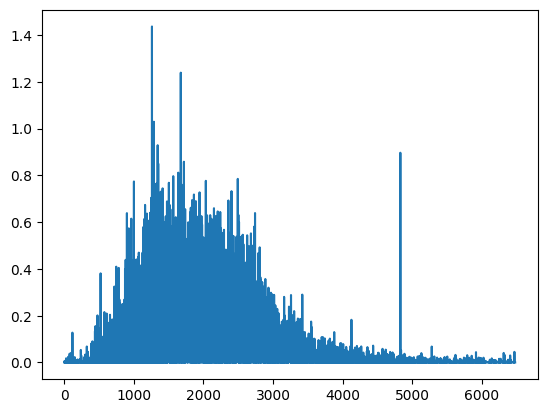

In [18]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[3,:])

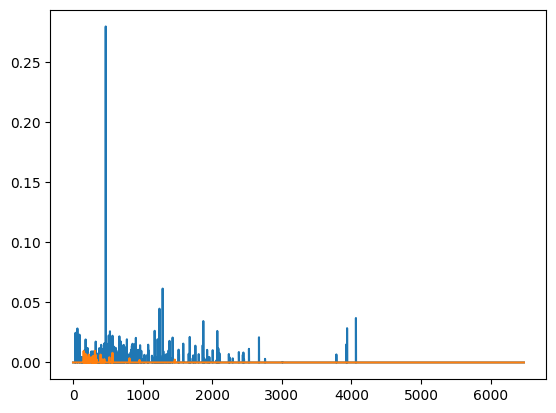

In [19]:
with torch.no_grad():
    fwd_output = engine.model((in_data, true_energy), True)
idx = 28
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:])

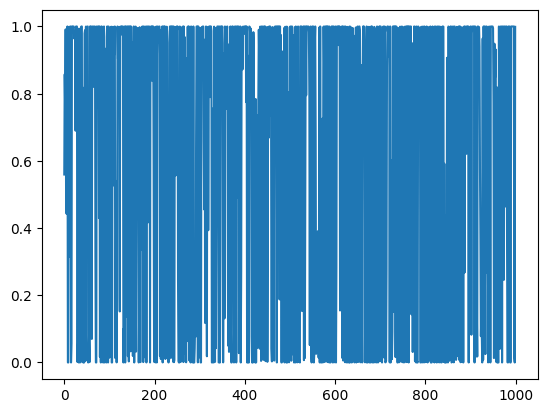

In [20]:
# enIn = torch.cat((in_data, true_energy), dim=1)
# beta, post_logits, post_samples = engine.model.encoder(enIn)
with torch.no_grad():
    beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy)
plt.plot(post_samples[0][0,:].detach().cpu().numpy())
post_samples = torch.cat(post_samples, 1)

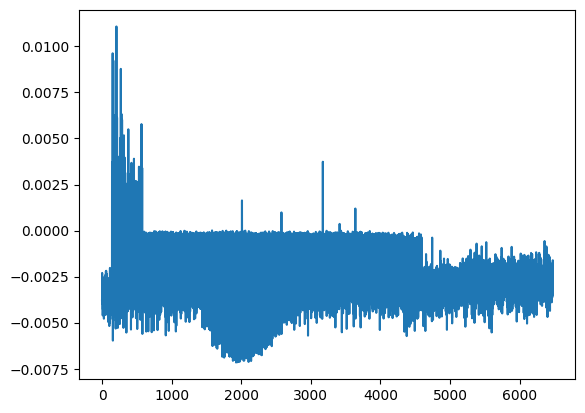

In [21]:
output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
plt.plot(output_activations[idx,:].detach().cpu().numpy())

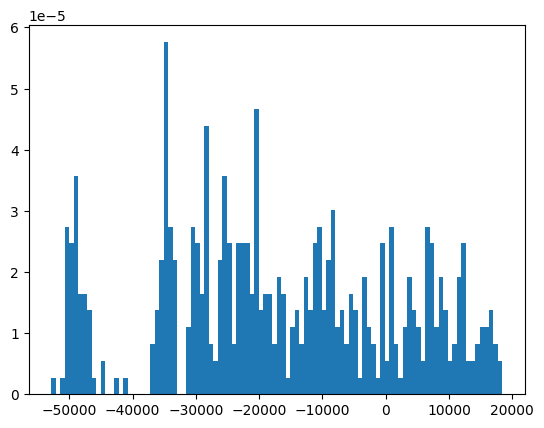

In [22]:
plt.hist(fwd_output.output_hits.sum(dim=1).detach().cpu().numpy(), bins=100, density=True)
# plt.hist(output_activations.sum(dim=1).detach().cpu().numpy(), bins=100, density=True)
# plt.plot(fwd_output.output_hits[idx,:].detach().cpu().numpy())
plt.show()

torch.Size([6480]) tensor(-14.5125, device='cuda:0')
torch.Size([512, 6480]) tensor([[ 2.8870,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [25.4611,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  8.4747,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 2.3549,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  4.7242,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


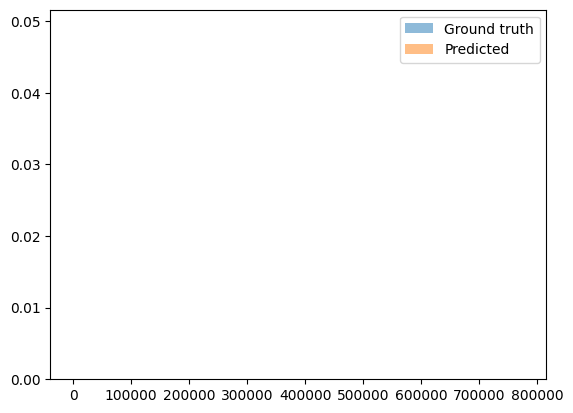

In [23]:
#xhat = (output_activations.detach().exp() - 1)*0.04*true_energy
xhat = output_activations.detach()
print(xhat[0].shape, torch.sum(xhat[0]))
print(xx[0][0].shape, xx[0][0])
#print(xx[1][0].shape, xx[1][0])
#plt.hist(np.log(xx[0][0].sum(dim=1).cpu().numpy() + 1e-10), bins=100, density=True)
plt.hist((xx[0][0].sum(dim=1).cpu().numpy()), bins=100, density=True, label = "Ground truth", alpha=0.5)   #Ground truth
#plt.hist(np.log(xhat.sum(dim=1).cpu().numpy() + 1e-10), bins=100, density=True)
plt.hist((xhat.sum(dim=1).cpu().numpy()), bins=100, density=True, label = 'Predicted', alpha=0.5)
#plt.xlim(left=-1)
#plt.xlim()
plt.legend()
plt.show()

In [24]:
model.loss(in_data, fwd_output, true_energy)

{'ae_loss': tensor(5.5068, device='cuda:0'),
 'kl_loss': tensor(-644.1567, device='cuda:0', grad_fn=<AddBackward0>),
 'hit_loss': tensor(1725.8370, device='cuda:0'),
 'entropy': tensor(-645.8124, device='cuda:0'),
 'pos_energy': tensor(-267.0320, device='cuda:0', grad_fn=<MeanBackward1>),
 'neg_energy': tensor(268.6877, device='cuda:0', grad_fn=<NegBackward0>),
 'label_loss': tensor(0.0595, device='cuda:0')}

In [25]:
en_labels = []
xtarget_samples = []
xrecon_samples = []
xitarget_samples = []
xirecon_samples = []
labelstarget_samples = []
labelsrecon_samples = []
for xx in val_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    fwd_output = engine.model((in_data, true_energy), True)
    # xVec = (fwd_output.output_activations.detach().exp() - 1)*0.04*true_energy
    
    xirecon_samples.append(fwd_output.output_activations.detach().cpu())
    # xrecon_samples.append( xVec.detach().cpu() )
    #xrecon_samples.append( torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy())) )
    xrecon_samples.append(torch.tensor(fwd_output.output_activations.detach().cpu().numpy())  )
    # labelsrecon_samples.append(fwd_output.labels.detach().cpu())
    
    xitarget_samples.append(in_data.detach().cpu())
    xtarget_samples.append(xx[0][0].detach().cpu() )
    # xtarget_samples.append( torch.tensor(engine._data_mgr.inv_transform(xx[0][0].detach().cpu().numpy())) )
    # labelstarget_samples.append( nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float).detach().cpu() )
    
    en_labels.append(true_energy.detach().cpu())
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
# labelstarget_samples = torch.cat(labelstarget_samples, dim=0)
xitarget_samples = torch.cat(xitarget_samples, dim=0)  
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xirecon_samples = torch.cat(xirecon_samples, dim=0) 
# labelsrecon_samples = torch.cat(labelsrecon_samples, dim=0)
en_labels = torch.cat(en_labels, dim=0)


# lhat = torch.argmax(nn.Sigmoid()(labelsrecon_samples), dim=1).numpy()
# l = torch.argmax(labelstarget_samples, dim=1).numpy()

In [26]:
print(en_labels.shape)

torch.Size([10000, 1])


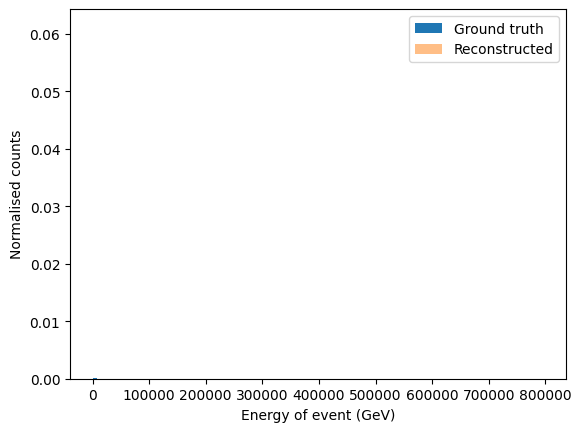

In [27]:
plt.hist(xtarget_samples.sum(dim=1).numpy(), bins=100, density=True, label = 'Ground truth')
plt.hist(xrecon_samples.sum(dim=1).numpy(), bins=100, density=True, alpha=0.5, label = 'Reconstructed')
plt.xlabel("Energy of event (GeV)")
plt.ylabel('Normalised counts')
#plt.xlim(0,1000)
#plt.ylim(0, 0.0001)
plt.legend()
plt.show()

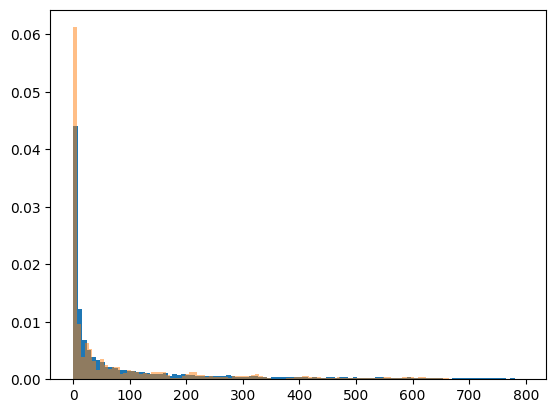

In [28]:
plt.hist(xitarget_samples.sum(dim=1).numpy(), bins=100, density=True)
plt.hist(xirecon_samples.sum(dim=1).numpy(), bins=100, density=True, alpha=0.5)
plt.show()

In [29]:
#Sparsity
for enIdx in en_labels.unique().numpy():
    idxBool = (en_labels == enIdx).nonzero(as_tuple=True)[0]
    xtargetTmp = xtarget_samples[idxBool,:]
    xreconTmp = xrecon_samples[idxBool, :]
    plt.hist(((xtargetTmp == 0).sum(dim=1)/533).numpy(), bins=50, density=True)
#   plt.hist(((xreconTmp == 0).sum(dim=1)/368).numpy(), bins=50, density=True, alpha=0.9)
plt.legend(list(en_labels.unique().numpy()))
plt.xlabel("Sparsity Index")  
plt.ylabel("PDF")
plt.title("Pions GT")
plt.show()

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 571x209497 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

In [30]:
#Sparsity
for enIdx in en_labels.unique().numpy():
    idxBool = (en_labels == enIdx).nonzero(as_tuple=True)[0]
    xtargetTmp = xtarget_samples[idxBool,:]
    xreconTmp = xrecon_samples[idxBool, :]
    # plt.hist(((xtargetTmp == 0).sum(dim=1)/368).numpy(), bins=50, density=True)
    plt.hist(((xreconTmp == 0).sum(dim=1)/533).numpy(), bins=50, density=True, alpha=0.9)
plt.legend(list(en_labels.unique().numpy()), bbox_to_anchor=(1.1, 1.05))
plt.xlabel("Sparsity Index")
plt.ylabel("PDF")
plt.title("Pions Recon")
plt.show()

ValueError: Image size of 762x209458 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

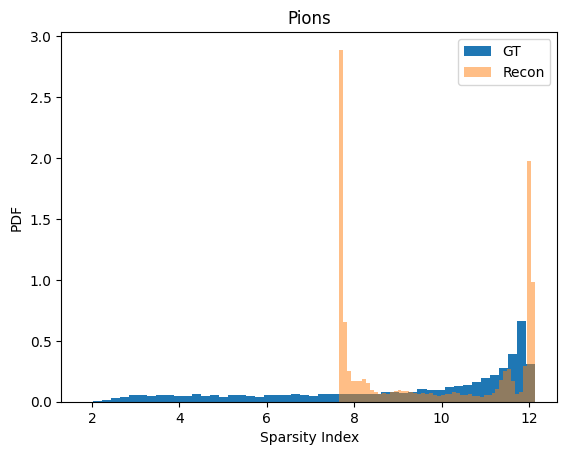

In [31]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/533).numpy(), bins=50, density=True)
plt.hist(((xrecon_samples == 0).sum(dim=1)/533).numpy(), bins=50, density=True, alpha=0.5)
#plt.hist(((xhat == 0).sum(dim=1)/533).cpu().numpy(), bins=50, density=True)
#plt.hist(((xtarget_samples == 0).sum(dim=1)/533).cpu().numpy(), bins=50, density=True, alpha=0.5)
plt.xlabel("Sparsity Index")
plt.ylabel("PDF")
plt.legend(["GT", "Recon"])
plt.title("Pions")
plt.show()

In [30]:
# plt.plot(l[:10])
# plt.plot(lhat[:10])
#np.sum(np.sign(np.abs(l - lhat)))/len(l)

In [31]:
xihat_samples.shape

NameError: name 'xihat_samples' is not defined

In [32]:

lhatSamp.shape
labelshat_samples.shape
5*15*1024
xhat_samples.shape

NameError: name 'lhatSamp' is not defined

In [33]:
# model.generate_samples(num_samples=1024, true_energy=0)

In [34]:
# sample_data

In [35]:
xhat_samples = []
xihat_samples = []
# labelshat_samples = []
with torch.no_grad():
    data_sampled = []
    for i in range(11):
        sample_energies, sample_data = model.generate_samples(num_samples=1024)
        #sample_energies, sample_data = model.generate_samples(num_samples=1024, true_energy=en)  #for unique energies
        #sample_energies, sample_data = model.generate_samples(num_samples=1024, true_energy=8000)  #for unique energy
        #data_sampled.append(sample_data.detach().cpu())
        #data_sampled.append(torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy())))
        data_sampled.append(torch.tensor(sample_data.detach().cpu().numpy())  )
    data_sampled = torch.cat(data_sampled, dim=0)
    # xhat_samples.append((data_sampled.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),en))
    xhat_samples.append(data_sampled)
    xihat_samples.append(data_sampled)
    # labelshat_samples.append(fwd_output.labels.detach().cpu())
xhat_samples = torch.cat(xhat_samples, dim=0)
xihat_samples = torch.cat(xihat_samples, dim=0)
# labelshat_samples = torch.cat(labelshat_samples, dim=0)

# lhatSamp = torch.argmax(nn.Sigmoid()(labelshat_samples), dim=1).numpy()

In [36]:
sam = []
for i in range(1):
    sample_energies, sample_data = model.generate_samples(num_samples=1000, true_energy=14)
    sam.append(sample_data.detach().cpu())
sam = torch.cat(sam, dim=0)

NameError: name 'sam' is not defined

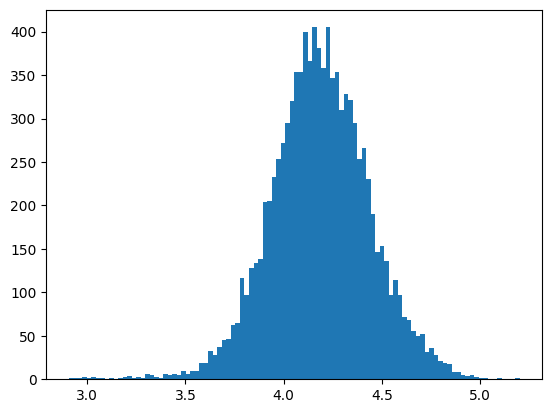

In [36]:
plt.hist(np.log(xtarget_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=False)
# plt.hist(np.log(xrecon_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.5)
# plt.hist(np.log(xhat_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.7)

sample_data_test = (sam.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),3.5)
plt.hist(np.log(sample_data_test.sum(dim=1).numpy() + 1e-10), bins=100, density=False, alpha=0.7)
plt.xlabel("Log of energy per event")
plt.ylabel("PDF")
plt.legend(["GT", "Sample"])
plt.title("Photons")
plt.show()

In [38]:
# xhat = (sample_data.detach().exp() - 1)*0.04*256*np.power(2,1)
# # plt.hist(xhat.sum(dim=1).cpu().numpy(), bins=100, density=True)
# plt.hist(np.log(xhat.sum(dim=1).cpu().numpy() + 1e-10), bins=100, density=True)
# plt.show()

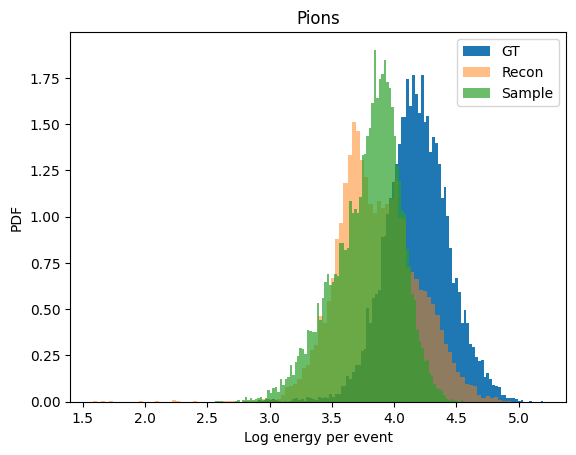

torch.Size([10001, 533]) torch.Size([10001, 533]) torch.Size([11264, 533])


In [37]:
plt.hist(np.log(xtarget_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True)
#plt.hist(xtarget_samples.sum(dim=1).numpy(), bins=100, density=True)
plt.hist(np.log(xrecon_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.5)
#plt.hist(xrecon_samples.sum(dim=1).numpy(), bins=100, density=True, alpha=0.5)
plt.hist(np.log(xhat_samples.sum(dim=1).numpy() + 1e-10), bins=100, density=True, alpha=0.7)
#plt.hist(xhat_samples.sum(dim=1).numpy(), bins=100, density=True, alpha=0.7)

# sample_data_test = (sam.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),0)
# plt.hist(np.log(sample_data_test.sum(dim=1).numpy() + 1e-10), bins=10, density=False, alpha=0.7)
plt.xlabel("Log energy per event")
plt.ylabel("PDF")
plt.legend(["GT", "Recon", "Sample"])
plt.title("Pions")
#plt.xlim(0, 100)
plt.show()

print(xtarget_samples.shape, xrecon_samples.shape, xhat_samples.shape)

Sorting sample events

In [38]:
unique_energies = torch.tensor([0, 2.5600e+02, 5.1200e+02, 1.0240e+03, 2.0480e+03, 4.0960e+03, 8.1920e+03,
        1.6384e+04, 3.2768e+04, 6.5536e+04, 1.3107e+05, 2.6214e+05, 5.2429e+05,
        1.0486e+06, 2.0972e+06, 4.1943e+06])/1000
energy_list = torch.unique(en_labels)
print(len(energy_list))

def Get_Unique_Energy_Events_samples(pions1_voxels, idx):  #idx goes from 1 - 15
    unique_energy_tensor = torch.tensor([])
    dataset = pions1_voxels
    print(f"Searching for events with energy in energy range {unique_energies[idx-1]} - {unique_energies[idx]}")
    for i in range(xhat_samples.shape[0]):
        if xhat_samples[i].unsqueeze(0).sum(dim=1).numpy() < unique_energies[idx].numpy()*1.1 and xhat_samples[i].unsqueeze(0).sum(dim=1).numpy() > unique_energies[idx-1].numpy():
            unique_energy_tensor = torch.cat((unique_energy_tensor, dataset[i,:].unsqueeze(0)), dim=0)
    print(unique_energy_tensor.shape, unique_energies[idx])
    return unique_energy_tensor
def Get_Unique_Energy_Events_recon(pions1_voxels, unique_energy_index):
    unique_energy_tensor = torch.tensor([])
    dataset = pions1_voxels
    unique_energy = energy_list[unique_energy_index]
    for i in range(en_labels.shape[0]):
        if en_labels[i] == unique_energy:
            unique_energy_tensor = torch.cat((unique_energy_tensor, dataset[i,:].unsqueeze(0)), dim=0)
    print(unique_energy_tensor.shape, unique_energy)
    return unique_energy_tensor
def Get_Unique_Energy_Events_input(pions1_voxels, unique_energy_index):
    unique_energy_tensor = torch.tensor([])
    dataset = pions1_voxels
    unique_energy = energy_list[unique_energy_index]
    for i in range(en_labels.shape[0]):
        if en_labels[i] == unique_energy:
            unique_energy_tensor = torch.cat((unique_energy_tensor, dataset[i,:].unsqueeze(0)), dim=0)
    print(unique_energy_tensor.shape, unique_energy)
    return unique_energy_tensor
print(energy_list)

1
tensor([8192.])


In [39]:
#Samples_Unique_Energies_data = [Get_Unique_Energy_Events_samples(xhat_samples, idx) for idx in range(1, len(energy_list))] if using all E data
Samples_Unique_Energies_data = [xhat_samples]
print(xhat_samples.shape)
Recon_Unique_Energies_data = [Get_Unique_Energy_Events_recon(xrecon_samples, idx) for idx in range(len(energy_list))]
Input_Unique_Energies_data = [Get_Unique_Energy_Events_input(xtarget_samples, idx) for idx in range(len(energy_list))]

torch.Size([11264, 533])
torch.Size([10001, 533]) tensor(8192.)
torch.Size([10001, 533]) tensor(8192.)


Calculate layer sparsities

In [40]:
def Get_Sparsity(pions1_voxels, lower_lim, upper_lim, layers):

    #layers_sparsities = np.zeros((pions1_voxels.shape[0], len(pion_layers)-1), dtype=np.float32)
    layer_datasets = [pions1_voxels[0][start_idx:end_idx] for start_idx, end_idx in zip(lower_lim, upper_lim)]
    layer_sp = [abs(np.count_nonzero(layer_dataset)/layer_dataset.shape[0]-1) for layer_dataset in layer_datasets]
    data_sparsities = torch.tensor(layer_sp)

    for i in range(1, pions1_voxels.shape[0]): #looping over all events
        layer_datasets = [pions1_voxels[i][start_idx:end_idx] for start_idx, end_idx in zip(pion_lower_lim, pion_upper_lim)]
        layer_sp = [abs(np.count_nonzero(layer_dataset)/layer_dataset.shape[0]-1) for layer_dataset in layer_datasets]
        data_sparsities = torch.cat((data_sparsities, torch.tensor(layer_sp)), dim=0)

    data_sparsities = data_sparsities.reshape(pions1_voxels.shape[0], len(layers)-1)
    return data_sparsities

In [41]:
pion_layers = np.array([0, 8, 108, 208, 213, 363, 523, 533])
pion_lower_lim = pion_layers[0:-1]
pion_upper_lim = pion_layers[1:]
Sample_Unique_Sparsities = [Get_Sparsity(x, pion_lower_lim, pion_upper_lim, pion_layers) for x in Samples_Unique_Energies_data]
Recon_Unique_Sparsities = [Get_Sparsity(x, pion_lower_lim, pion_upper_lim, pion_layers) for x in Recon_Unique_Energies_data]
Input_Unique_Sparsities = [Get_Sparsity(x, pion_lower_lim, pion_upper_lim, pion_layers) for x in Input_Unique_Energies_data]
print(Sample_Unique_Sparsities[0].shape)

torch.Size([11264, 7])


In [42]:
#print(torch.sum(Recon_Unique_Energies_data[6][1], dim=0))

Calculate fractional energies

In [43]:
epsilon = 1e-8
def Get_Fractional_Energy_per_Layer_per_Energy(idx, lower_lim, upper_lim, layers, epsilon, data):
    #idx chooses specific energy from energy_list defined above
    if data == 0:
        dataset = Samples_Unique_Energies_data[idx]   #change from pions to photons here
    elif data == 1:
        dataset = Recon_Unique_Energies_data[idx]
    elif data == 2:
        dataset = Input_Unique_Energies_data[idx]
    else:
        return "Invalid dataset"
    
    reshape_counter = 0  #removing events where 0 energy is deposited in the calorimeter with if/else statement in loop
    for j in range(5):
        if torch.sum(dataset[j]) != 0.:
            layer_datasets = [dataset[j][start_idx:end_idx] for start_idx, end_idx in zip(lower_lim, upper_lim)]
            layer_frac = [torch.sum(layer_dataset, dim=0)/torch.sum(dataset[j], dim=0) for layer_dataset in layer_datasets]
            frac_e_per_layer = torch.tensor(layer_frac)
            break
        else:
            reshape_counter += 1
    
    for i in range(j+1, dataset.shape[0]): #looping over all events
        if torch.sum(dataset[i]) != 0.:
            layer_datasets = [dataset[i][start_idx:end_idx] for start_idx, end_idx in zip(lower_lim, upper_lim)]
            layer_frac = [torch.sum(layer_dataset, dim=0)/(torch.sum(dataset[i], dim=0)+epsilon) for layer_dataset in layer_datasets]
            frac_e_per_layer = torch.cat((frac_e_per_layer, torch.tensor(layer_frac)), dim=0)
        else:
            reshape_counter += 1
        
    frac_e_per_layer = frac_e_per_layer.reshape(dataset.shape[0]-reshape_counter, len(layers)-1)
    return frac_e_per_layer

In [44]:
sample_unique_frac_energiesGeV8 = Get_Fractional_Energy_per_Layer_per_Energy(0, pion_lower_lim, pion_upper_lim, pion_layers, epsilon, 0)
#sample_unique_frac_energiesGeV16 = Get_Fractional_Energy_per_Layer_per_Energy(0, pion_lower_lim, pion_upper_lim, pion_layers, epsilon, 0)
recon_unique_frac_energiesGeV8 = Get_Fractional_Energy_per_Layer_per_Energy(0, pion_lower_lim, pion_upper_lim, pion_layers, epsilon, 1)
#recon_unique_frac_energiesGeV16 = Get_Fractional_Energy_per_Layer_per_Energy(0, pion_lower_lim, pion_upper_lim, pion_layers, epsilon, 1)
input_unique_frac_energiesGeV8 = Get_Fractional_Energy_per_Layer_per_Energy(0, pion_lower_lim, pion_upper_lim, pion_layers, epsilon, 2)
#input_unique_frac_energiesGeV16 = Get_Fractional_Energy_per_Layer_per_Energy(0, pion_lower_lim, pion_upper_lim, pion_layers, epsilon, 2)

In [47]:
print(input_unique_frac_energiesGeV16)

NameError: name 'input_unique_frac_energiesGeV16' is not defined

Create sparsity plots

tensor([0.5424])
tensor([0.6757])
tensor([0.3808])
tensor([0.7475])
tensor([0.8321])


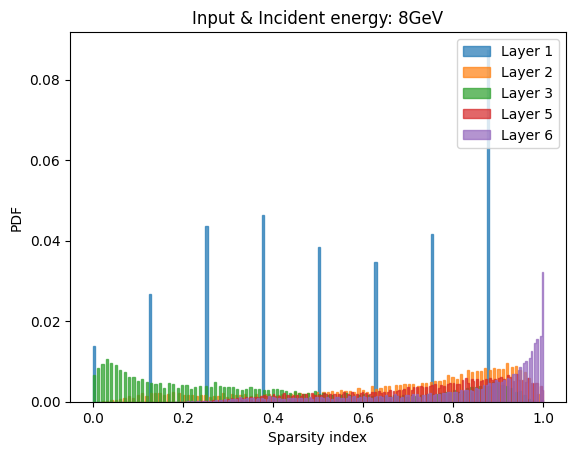

In [45]:
#print(Recon_Unique_Sparsities[6].shape)
i=0
for layer_n in [1, 2, 3, 5, 6]: 
#layer_n = 3
    i+=1
    idx = 0  #energy_index in energy_list   #5=>8GeV, 6=>16GeV
    #for idx in range(len(Unique_sparsities)):
    energy_to_display = unique_energies[idx+1]
    #print("energy plotted is", energy_to_display)
    data = Input_Unique_Sparsities[idx]                    #Change samples///recon//input here!!!!!!!!!!!!
    #weights = np.ones_like(tensor[:, layer_n-1])/float(pions1_voxels.shape[0])   #dividing by total number of pion events to normalize histogram over all events
    weights = np.ones_like(data[:, layer_n-1])/(float(len(data[:, layer_n-1])*3)) #for individual layers
    #plt.hist(torch.log(data[:, layer_n-1]+epsilon), bins=200, weights=weights, label = f'Layer: {layer_n}', histtype='step', stacked=True, fill=True)
    plt.hist(data[:, layer_n-1], bins=200, weights=weights, alpha=0.7, label = f'Layer {layer_n}', histtype='step', stacked=True, fill=True)
    plt.ylabel("PDF")
    plt.xlabel("Sparsity index")
   # plt.title(f'Reconstructed and Incident energy: {np.round(energy_to_display)} GeV') #for all energies
    plt.title('Input & Incident energy: 8GeV')
    plt.legend()
    print(torch.mean(data[:, layer_n-1].unsqueeze(0), dim=1))
#plt.ylim(0., 0.04)
plt.show()


Create fractional energy plots

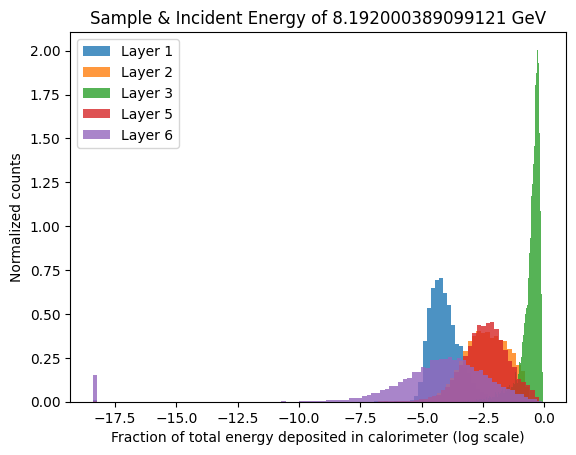

In [46]:
#print(sample_unique_frac_energiesGeV16.shape[0])
#for i in range(sample_unique_frac_energiesGeV8.shape[1]-1):
for i in [0, 1, 2, 4, 5]:
    #weights = (np.ones_like(GeV[:,i])+epsilon)/float(GeV.shape[0]*(GeV.shape[1]-1))
    plt.hist(torch.log(sample_unique_frac_energiesGeV8[:,i]+epsilon), bins=100, label = f'Layer {i+1}', alpha=0.8, density=True)
    #plt.hist(GeV[:,i], weights=weights, bins=100, label = f'Layer {i+1}', alpha=0.8, density=True)
plt.xlabel('Fraction of total energy deposited in calorimeter (log scale)')
plt.ylabel('Normalized counts')
plt.title(f'Sample & Incident Energy of {unique_energies[6]} GeV')
#plt.xlim(0., 1.)
#plt.ylim(0, 0.042)
plt.legend()
plt.show()

In [47]:
#sample_GeV_list = [sample_unique_frac_energiesGeV8, sample_unique_frac_energiesGeV16]
#print(torch.mean(sample_GeV_list[0], dim=0), torch.mean(sample_GeV_list[1], dim=0))
#recon_GeV_list = [recon_unique_frac_energiesGeV8, recon_unique_frac_energiesGeV16]
#print(torch.mean(recon_GeV_list[0], dim=0), torch.mean(recon_GeV_list[1], dim=0))
#input_GeV_list = [input_unique_frac_energiesGeV8, input_unique_frac_energiesGeV16]
#print(torch.mean(input_GeV_list[0], dim=0), torch.mean(input_GeV_list[1], dim=0))

In [48]:
samples_33 = Get_Fractional_Energy_per_Layer_per_Energy(0, pion_lower_lim, pion_upper_lim, pion_layers, epsilon, 0)
recon_33 = Get_Fractional_Energy_per_Layer_per_Energy(0, pion_lower_lim, pion_upper_lim, pion_layers, epsilon, 1)
input_33 = Get_Fractional_Energy_per_Layer_per_Energy(0, pion_lower_lim, pion_upper_lim, pion_layers, epsilon, 2)
print(torch.mean(samples_33, dim=0), torch.mean(recon_33, dim=0), torch.mean(input_33, dim=0))
#print([torch.mean(Get_Fractional_Energy_per_Layer_per_Energy(i, pion_lower_lim, pion_upper_lim, pion_layers, epsilon, 2),dim=0) for i in range(15)])

tensor([0.0206, 0.1326, 0.6210, 0.0428, 0.1332, 0.0492, 0.0007]) tensor([0.0289, 0.1489, 0.4652, 0.0366, 0.1918, 0.1255, 0.0032]) tensor([0.0255, 0.1769, 0.4000, 0.0290, 0.2179, 0.1461, 0.0046])


Comparing fractional energies over different layers for input, recon and samples

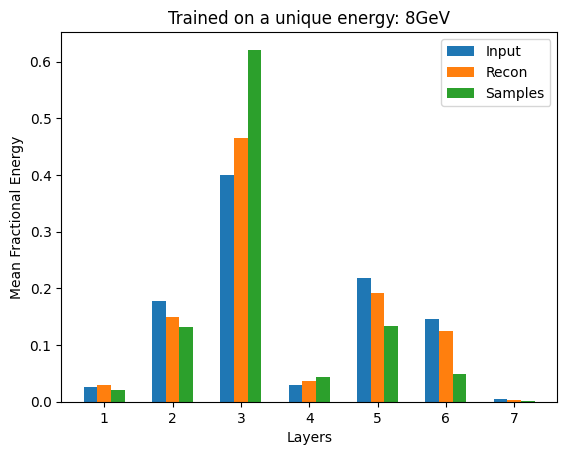

In [49]:
labels = ['Input', 'Recon', 'Samples']
avgs_samples = torch.mean(samples_33, dim=0)
avgs_recon = torch.mean(recon_33, dim=0)
avgs_input = torch.mean(input_33, dim=0)
x = np.arange(1,8)
bar_width = 0.2
plt.bar(x-bar_width, avgs_input,width=bar_width, label=labels[0])
plt.bar(x, avgs_recon, width=bar_width, label=labels[1])
plt.bar(x+bar_width, avgs_samples, width=bar_width, label=labels[2])
plt.legend(prop={'size': 10})
#plt.set_title('bars with legend')
plt.xlabel("Layers")
plt.ylabel("Mean Fractional Energy")
plt.title("Trained on a unique energy: 8GeV")
plt.show()

Comparing sparsities over different layers for input, recon and samples

tensor([0.5534, 0.7084, 0.2550, 0.2028, 0.7665, 0.9013, 0.9792])


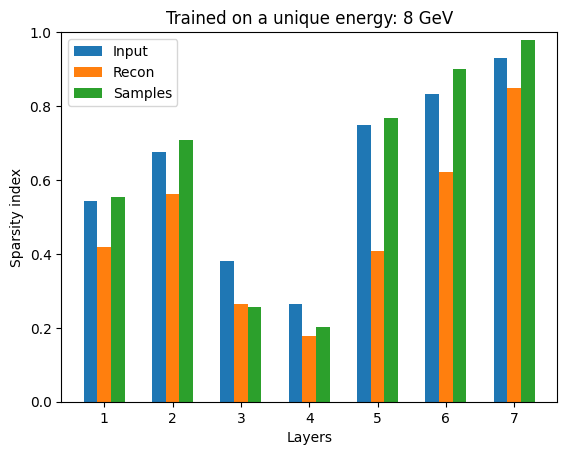

In [50]:
labels = ['Input', 'Recon', 'Samples']
avgs_samples = torch.mean(Sample_Unique_Sparsities[0], dim=0)
print(avgs_samples)
avgs_recon = torch.mean(Recon_Unique_Sparsities[0], dim=0)
avgs_input = torch.mean(Input_Unique_Sparsities[0], dim=0)
x = np.arange(1,8)
bar_width = 0.2
plt.bar(x-bar_width, avgs_input,width=bar_width, label=labels[0])
plt.bar(x, avgs_recon, width=bar_width, label=labels[1])
plt.bar(x+bar_width, avgs_samples, width=bar_width, label=labels[2])
plt.legend(prop={'size': 10})
#plt.set_title('bars with legend')
plt.xlabel("Layers")
plt.ylabel("Sparsity index")
plt.title("Trained on a unique energy: 8 GeV")
plt.ylim(0.,1.)
plt.show()

In [157]:
placeholder_Es = samples_33
placeholder_Ei = input_33
placeholder_Er = recon_33

In [156]:
placeholder_Ss = sample_unique_frac_energiesGeV8
placeholder_Si = input_unique_frac_energiesGeV8
placeholder_Sr = recon_unique_frac_energiesGeV8

In [ ]:
plt.hist(xitarget_samples.sum(dim=1).numpy(), bins=100, density=True)
plt.hist(xirecon_samples.sum(dim=1).numpy(), bins=100, density=True, alpha=0.5)
plt.hist(xihat_samples.sum(dim=1).numpy(), bins=100, density=True, alpha=0.5)
plt.xlabel("ξ per event")
plt.ylabel("PDF")
plt.legend(["GT", "Recon", "Sample"])
plt.title("Photons")
plt.show()

In [358]:
# GT and Recon Comparison

In [55]:
sampDataAll, sampDataOutAll = np.array([]), np.array([])
for xx in val_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    fwd_output = engine.model((in_data, true_energy), True)
    
    sampDataAll = np.append(sampDataAll, np.sum(in_data.detach().cpu().numpy(), axis=1))
    sampDataOutAll = np.append(sampDataOutAll, np.sum(fwd_output.output_activations.detach().cpu().numpy(), axis=1))

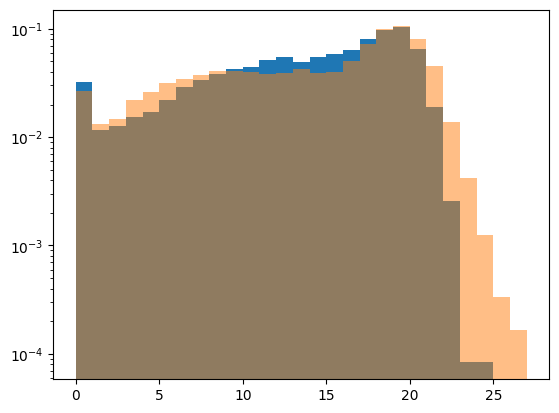

In [56]:
binwidth = 1

plt.hist(sampDataAll, bins=range(int(np.floor(min(sampDataAll))), int(np.ceil(max(sampDataAll))) + binwidth, binwidth), log=True, density=True)
plt.hist(sampDataOutAll, bins=range(int(np.floor(min(sampDataOutAll))), int(np.ceil(max(sampDataOutAll))) + binwidth, binwidth), log=True, density=True, alpha = 0.5)
plt.show()

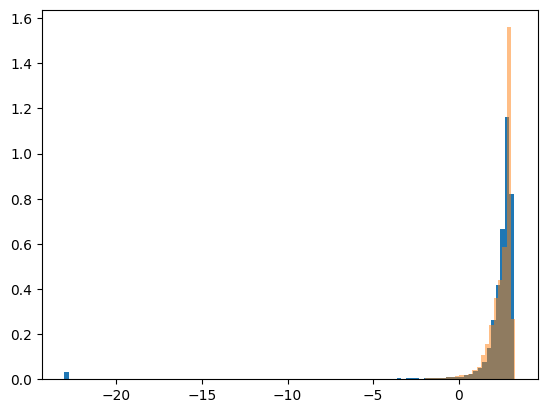

In [57]:
binwidth = 1
plt.hist(np.log(sampDataAll + 1e-10), bins=100, density=True)
plt.hist(np.log(sampDataOutAll + 1e-10), bins=100, density=True, alpha = 0.5)
plt.show()

In [33]:
# model

In [31]:
# model._hit_smoothing_dist_mod #(output_hits, beta, is_training)

In [89]:
seq1 = nn.Sequential(
                   # nn.Linear(self.num_input_nodes, 24*24),
                   # nn.Unflatten(1, (1,24, 24)),
    
                   nn.Conv2d(1, 16, 3, 1, 0),
                   nn.BatchNorm2d(16),
                   nn.PReLU(16, 0.02),
                )
sequential2 = nn.Sequential(
                   nn.Conv2d(17, 32, 3, 1, 0),
                   # nn.MaxPool2d(2,stride=2),
                   
                   nn.PReLU(32, 0.02),
                   nn.BatchNorm2d(32),
                )

sequential3 = nn.Sequential(
                   nn.Conv2d(33, 64, 3, 1, 0),
                   nn.BatchNorm2d(64),
                   nn.PReLU(64, 0.02),
                )

sequential4 = nn.Sequential(
                   nn.Conv2d(65, 128, 3, 1, 0),
                   nn.MaxPool2d(2,stride=2),
                   
                   nn.PReLU(128, 0.02),
                   nn.BatchNorm2d(128),
                   

                   nn.Conv2d(128, 256, 3, 1, 0),
                   nn.BatchNorm2d(256),
                   nn.PReLU(256, 0.02),
                   

                   nn.Conv2d(256, 512, 2, 1, 0),
                   nn.BatchNorm2d(512),
                   nn.PReLU(512, 0.02),
                   
    
                   nn.Conv2d(512, 1024, 2, 1, 0),
                   nn.MaxPool2d(2,stride=2),
                   nn.BatchNorm2d(1024),
                   nn.PReLU(1024, 0.02),

                    nn.Conv2d(1024, 1000, 2, 1, 0),
                   # nn.MaxPool2d(2,stride=2),
                   # nn.PReLU(self.n_latent_nodes, 0.02),
                   nn.Sigmoid(),
                   # nn.BatchNorm2d(self.n_latent_nodes),
    
                   nn.Flatten(),
                )


In [90]:
x = torch.rand(2,1,24,24)
x0 = torch.ones(2,1)*3
minEnergy = 3
x = seq1(x)
x = torch.cat((x, x0.unsqueeze(2).unsqueeze(3).repeat(1,1,torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item()).divide(minEnergy).log2()), 1)
x = sequential2(x)
x = torch.cat((x, x0.unsqueeze(2).unsqueeze(3).repeat(1,1,torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item()).divide(minEnergy).log2()), 1)
x = sequential3(x)
x = torch.cat((x, x0.unsqueeze(2).unsqueeze(3).repeat(1,1,torch.tensor(x.shape[-2:-1]).item(), torch.tensor(x.shape[-1:]).item()).divide(minEnergy).log2()), 1)
x = sequential4(x)

x.shape



# tuple(torch.tensor(x.shape[-2:]).tolist())
# tuple([1,2])
# torch.tensor(x.shape[-2:-1]).item()

torch.Size([2, 1000])

In [ ]:
nn.Sequential(
                   nn.Linear(self.num_input_nodes, 24*24),
                   nn.Unflatten(1, (1,24, 24)),
    
                   nn.Conv2d(1, 16, 3, 1, 0),
                   nn.BatchNorm2d(64),
                   nn.PReLU(16, 0.02),
                )
        self.sequential2 = nn.Sequential(
                   nn.Conv2d(65, 128, 3, 1, 0),
                   nn.MaxPool2d(2,stride=2),
                   
                   nn.PReLU(128, 0.02),
                   nn.BatchNorm2d(128),
                   

                   nn.Conv2d(128, 256, 3, 1, 0),
                   nn.BatchNorm2d(256),
                   nn.PReLU(256, 0.02),
                   

                   nn.Conv2d(256, 512, 2, 1, 0),
                   nn.BatchNorm2d(512),
                   nn.PReLU(512, 0.02),
                   
    
                   nn.Conv2d(512, 1024, 2, 1, 0),
                   nn.MaxPool2d(2,stride=2),
                   nn.BatchNorm2d(1024),
                   nn.PReLU(1024, 0.02),